![header](../figures/logos_partenaires._cmems_se.jpg)

# Benchmark SWOT Swath Filtering

<div style="text-align: right"><i> 2022-09-20 GOMEZ_BENCHMARK_DEMO </i></div>

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2022 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark of Gomez filter</center></h1></div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can display unfiltered, filtered SWOT Level3 SSH products.</li>
  <li>How you can evaluate the Gomez filter: statistical and spectral analysis.</li>
</ul>
    
</div>



In [1]:
import os
import glob
import sys
sys.path.append('..')
from src.benchmark import *
from src.plot import *
from src.swot import *

Bad value in file '/home/mballarotta/.config/matplotlib/matplotlibrc', line 38 ('backend      : qt4agg'): Key backend: 'qt4agg' is not a valid value for backend; supported values are ['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']


<div class="alert alert-info" role="alert">

<h2>1. Input files to analyse</h2>

</div>

## Data challenge inputs

In [2]:
# Check if inputs have already been downloaded otherwise do
if not os.path.isdir('../dc_inputs'):
    # Get pseuso-observation
    !wget https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ocean-data-challenges/2022a_SWOT_karin_error_filtering/dc_inputs.tar.gz
    !tar -xvf dc_inputs.tar.gz --directory ../
    !rm -f dc_inputs.tar.gz

In [3]:
list_of_file_inputs = sorted(glob.glob('../dc_inputs/input_ssh_karin_013_*.nc')) 

## Filtered outputs to evaluate

In [4]:
list_of_file = sorted(glob.glob('../inputs/eNATL60-BLB002/gomez/SWOT_L2_LR_Filtered_013_*.nc')) 

<div class="alert alert-info" role="alert">

<h2>2. Illustration on one pass (same as quickstart example)</h2>

</div>

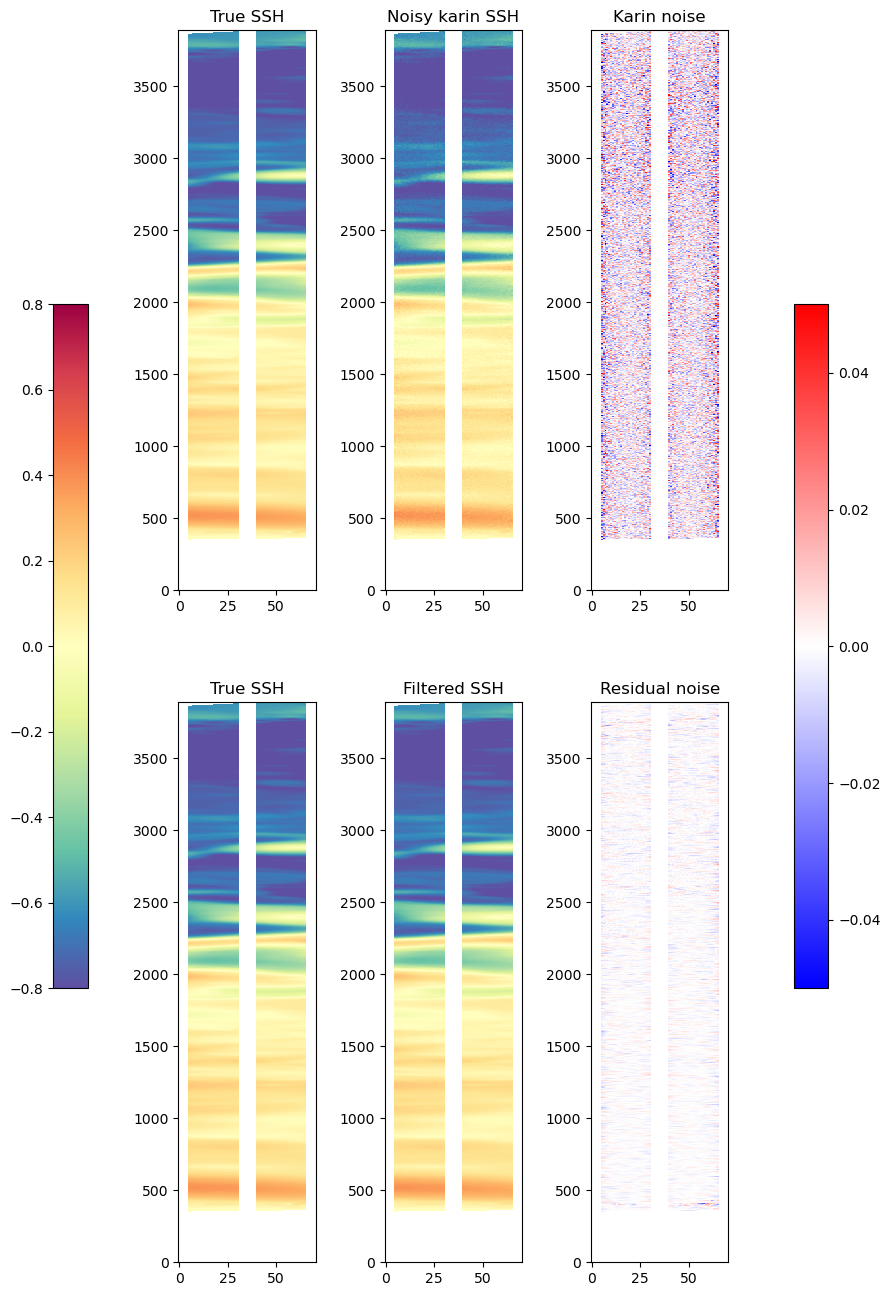

In [5]:

swt_filtered = SwotTrack(list_of_file[3])
swt_input = SwotTrack(list_of_file_inputs[3])

n_p, n_l = np.meshgrid(swt_input._dset.num_pixels.values,swt_input._dset.num_lines.values)
fig, axs = plt.subplots(2, 3,figsize=(10,16))
row,col = 0,0
ax = axs[row,col]
ssh_true = swt_input._dset.ssh_true.values
msk = np.isnan(swt_input._dset.ssh_karin)
ssh_true[msk] = np.nan
ax.pcolormesh(n_p,n_l,ssh_true,vmin=-0.8,vmax=0.8,cmap='Spectral_r') 
ax.title.set_text('True SSH')

row,col = 1,0
ax = axs[row,col] 
pcm =ax.pcolormesh(n_p,n_l,ssh_true,vmin=-0.8,vmax=0.8,cmap='Spectral_r') 
ax.title.set_text('True SSH')

fig.colorbar(pcm, ax=axs[:,col], shrink=0.6,location='left') 


row,col = 0,1
ax = axs[row,col]
ssh_karin = swt_input._dset.ssh_karin.values
ax.pcolormesh(n_p,n_l,ssh_karin,vmin=-0.8,vmax=0.8,cmap='Spectral_r') 
ax.title.set_text('Noisy karin SSH')

row,col = 1,1
ax = axs[row,col]
ssh_karin_filtered = swt_filtered._dset.ssh_karin_filt.values
pcm =ax.pcolormesh(n_p,n_l,ssh_karin_filtered,vmin=-0.8,vmax=0.8,cmap='Spectral_r') 
ax.title.set_text('Filtered SSH')

cb=fig.colorbar(pcm, ax=axs[:,col], shrink=0.6) 
cb.remove()
  
row,col = 0,2
ax = axs[row,col]
ssh_diff = ssh_true-ssh_karin
ax.pcolormesh(n_p,n_l,ssh_diff,vmin=-0.05,vmax=0.05,cmap='bwr') 
ax.title.set_text('Karin noise')

row,col = 1,2
ax = axs[row,col]
ssh_diff_filtered = ssh_true-ssh_karin_filtered
pcm =ax.pcolormesh(n_p,n_l,ssh_diff_filtered,vmin=-0.05,vmax=0.05,cmap='bwr') 
ax.title.set_text('Residual noise')

fig.colorbar(pcm, ax=axs[:,col], shrink=0.6) 
 

plt.subplots_adjust(left=0.25,wspace=0.5,right=0.8) 

fig.show() 

<div class="alert alert-info" role="alert">

<h2>3. Statistical & Spectral Analysis </h2>

</div>

## 3.1 Parameters

In [6]:
etuvar = 'ssh_karin_filt'
filter_name = 'GOMEZ'
output_dir = '../results'
stat_output_filename = f'{output_dir}/stat_GOMEZ.nc'
stat_by_regime_output_filename = f'{output_dir}/stat_by_regime_GOMEZ.nc'
psd_output_filename = f'{output_dir}/psd_GOMEZ.nc'
gomez_bench = Benchmark()

## 3.2 Compute grid boxes statistics

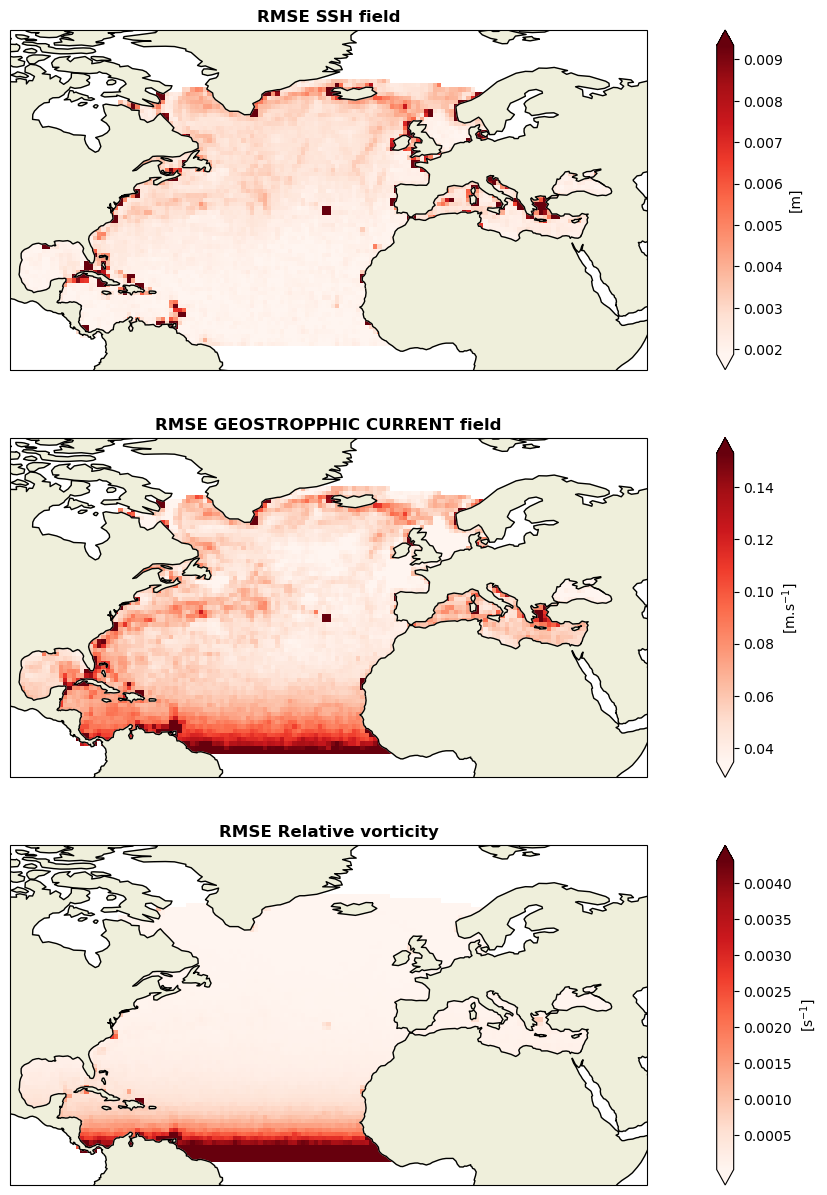

CPU times: user 1min 5s, sys: 1.41 s, total: 1min 7s
Wall time: 2min 29s


In [7]:
%%time
# Compute gridded stats
gomez_bench.compute_stats(list_of_file, etuvar, list_of_file_inputs)

# Write gridded stats 
gomez_bench.write_stats(stat_output_filename, filter=filter_name)

# Plot gridded stats
gomez_bench.display_stats(stat_output_filename, xlim=(-100, 50), ylim=(0, 80))

## 3.3 Compute statistics by regime (coastal, offshore low variability, offshore high variability)

In [8]:
# To speed up computation
from dask.distributed import Client
client = Client(n_workers=8, threads_per_worker=8, memory_limit='8GB')
client

<Client: 'tcp://127.0.0.1:41137' processes=8 threads=64, memory=59.60 GiB>

Bad value in file '/home/mballarotta/.config/matplotlib/matplotlibrc', line 38 ('backend      : qt4agg'): Key backend: 'qt4agg' is not a valid value for backend; supported values are ['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
Bad value in file '/home/mballarotta/.config/matplotlib/matplotlibrc', line 38 ('backend      : qt4agg'): Key backend: 'qt4agg' is not a valid value for backend; supported values are ['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
Bad value in file '/home/mballarotta/.config/matplotlib/matplotlibrc', line 38 ('backend      : qt4agg'): Key backend: 'qt4agg' is not a valid value for backend; supported values are ['GTK3Agg

CPU times: user 3min 12s, sys: 41.8 s, total: 3min 53s
Wall time: 8min 27s


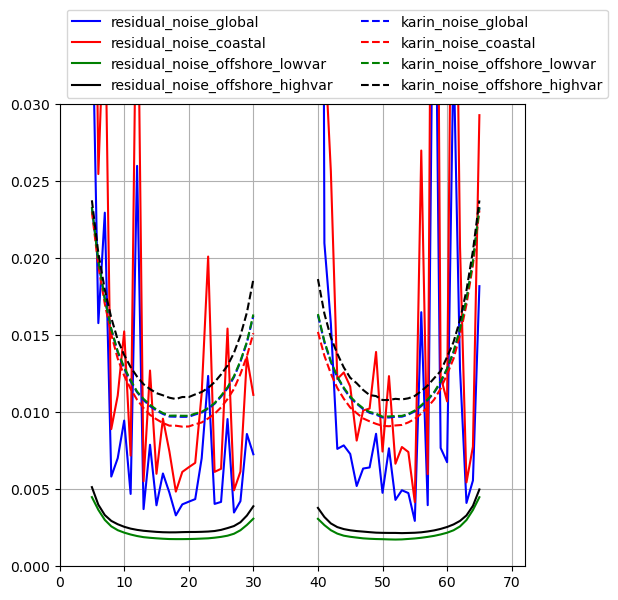

In [9]:
%%time
# Compute stats by regime
gomez_bench.compute_stats_by_regime(list_of_file, etuvar, list_of_file_inputs)

# Write stats by regime
gomez_bench.write_stats_by_regime(stat_by_regime_output_filename, filter=filter_name)

# Plot stats by regime
gomez_bench.plot_stats_by_regime(stat_by_regime_output_filename)

In [10]:
client.close()

## 3.4 Compute Spectral scores

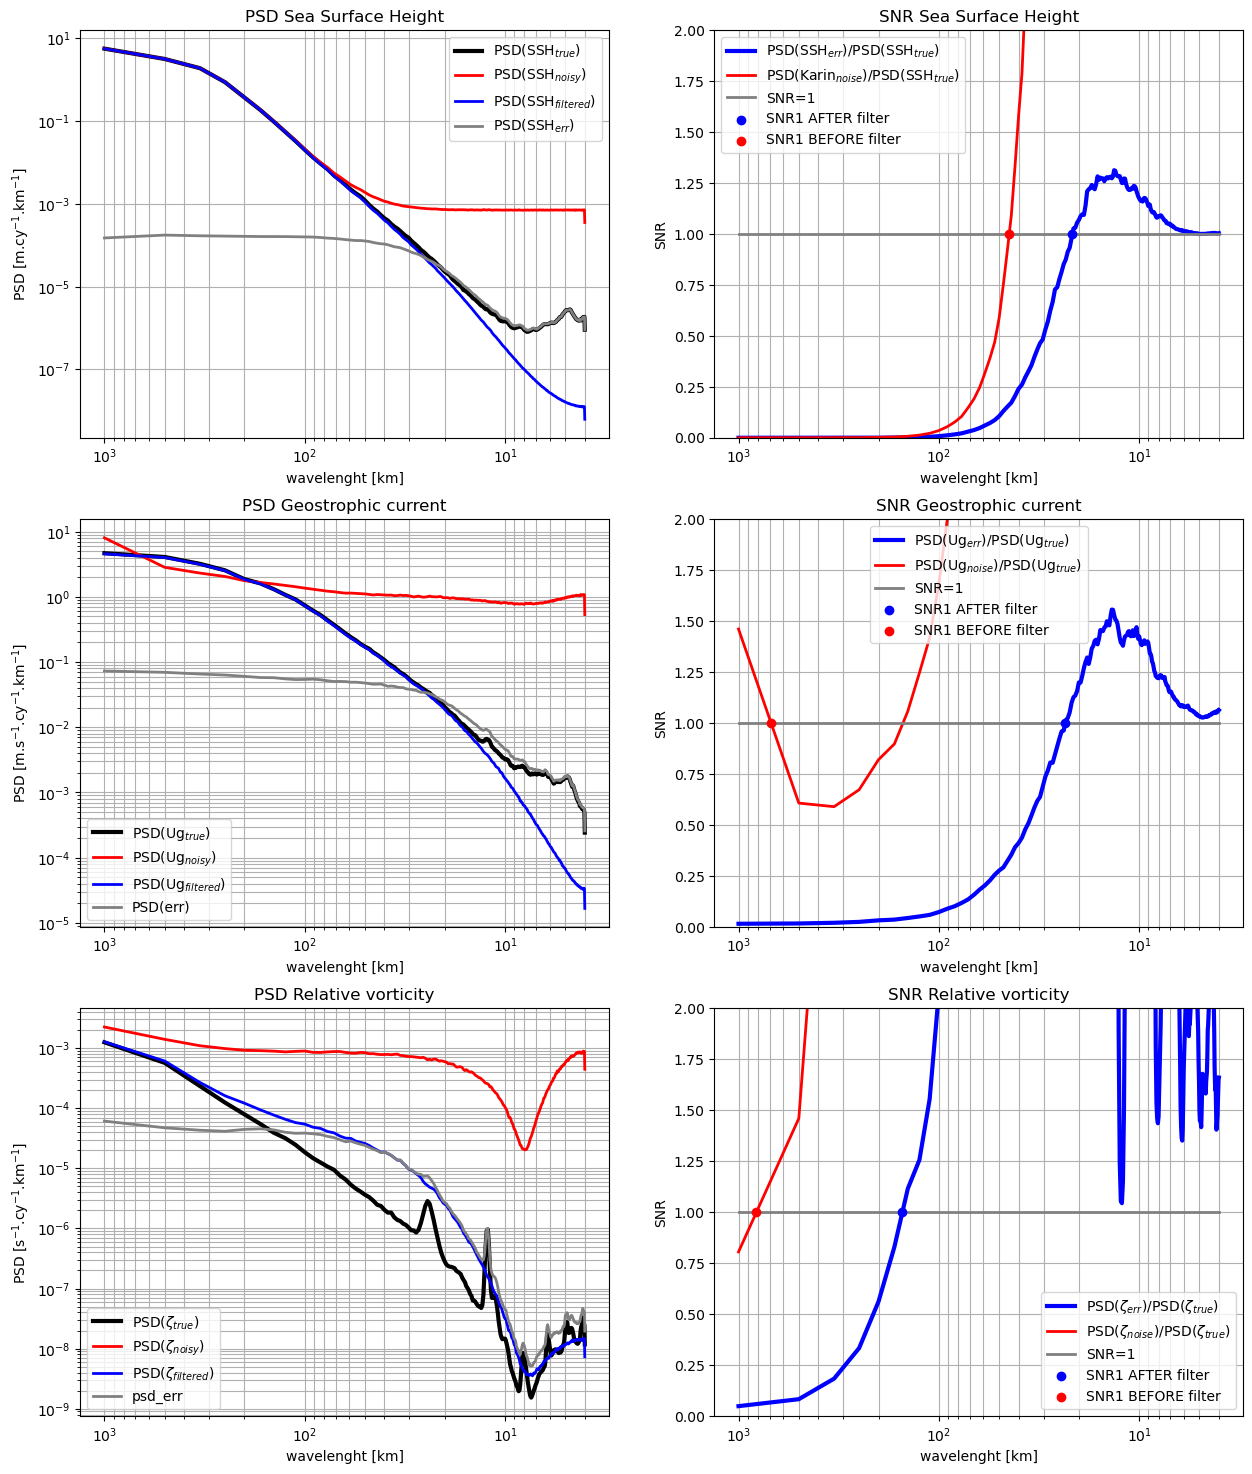

CPU times: user 47 s, sys: 2.54 s, total: 49.5 s
Wall time: 2min 37s


In [11]:
%%time
# Compute PSD scores
gomez_bench.compute_along_track_psd(list_of_file, etuvar,list_of_file_inputs, lengh_scale=1000)

# Write PSD scores
gomez_bench.write_along_track_psd(psd_output_filename, filter=filter_name)

# Plot PSD scores
gomez_bench.display_psd(psd_output_filename)

<div class="alert alert-info" role="alert">

<h2>4. Leaderboard </h2>

</div>

In [12]:
gomez_bench.summary('demo_benchmark_GOMEZ.ipynb')

Summary of the leaderboard metrics:
|    | Method   | Field                          |   µ(RMSE global) |   µ(RMSE coastal) |   µ(RMSE offshore lowvar) |   µ(RMSE offshore highvar) |   λ(SNR1 before filtering) [km] |   λ(SNR1 after filtering) [km] | Reference                  |
|---:|:---------|:-------------------------------|-----------------:|------------------:|--------------------------:|---------------------------:|--------------------------------:|-------------------------------:|:---------------------------|
|  0 | GOMEZ    | SSH [m]                        |       0.0246842  |        0.0404012  |                0.00232776 |                0.00275293  |                            44.5 |                           21.5 | demo_benchmark_GOMEZ.ipynb |
|  1 | GOMEZ    | Geostrophic current [m.s$^-1$] |       0.202053   |        0.323186   |                0.0644855  |                0.0560844   |                           687.5 |                           23.4 | demo_benchmark_GOMEZ.